In [1]:
import sys
sys.path.insert(0, './../')

import os
import utils_modelling as utils

In [2]:
path_dataset = "./../../../dataset_used_split_aug"
path_test = os.path.join(path_dataset, "test")
test_img, test_mask = utils.load_img_mask(path_test)
testset = utils.create_dataset(test_img, test_mask)

In [3]:
predicted_mask, model = utils.predict_model(testset, "unet_model_aug")

1/1 [==============================] - 11s 11s/step


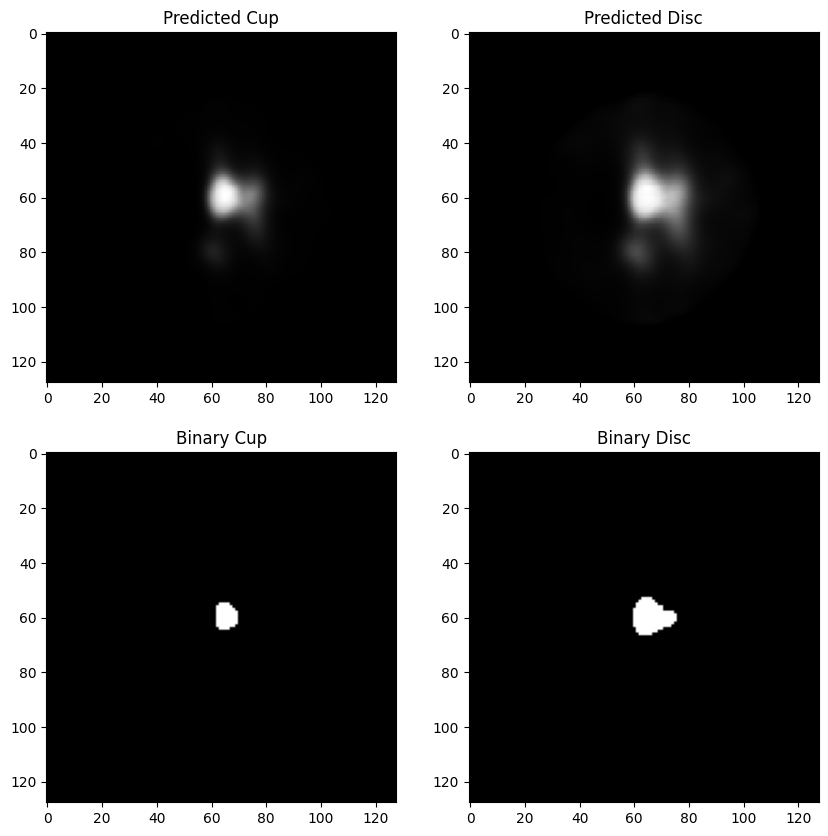

In [30]:
cup_mask, disc_mask, bcup_mask, bdisc_mask = utils.split_disc_cup_mask(predicted_mask, treshold=.2, img_idx=13)

In [10]:
import matplotlib.pyplot as plt

Image shape:  (128, 128, 1)


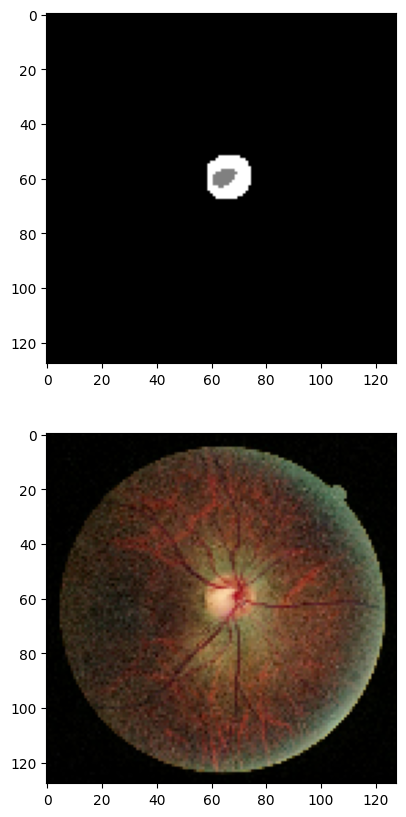

In [31]:
for image, mask in testset.take(1):
    idx=13
    print("Image shape: ", mask[idx].shape)
    plt.figure(figsize=(10, 10))
    plt.subplot(2,1, 1)
    plt.imshow(mask[idx], cmap="gray")
    plt.subplot(2,1, 2)
    plt.imshow(image[idx])

Metrics:
- IoU
- Dice Score
- Precision
- Recal